# Portfolio research agent

We will use the Swarm pattern, in which multiple agents will carry out their specialized tasks in parallel. Eventually the outputs from the agents will be aggregated to produce the final result.

In [15]:
from dotenv import load_dotenv

from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain.chat_models import init_chat_model

# CHANGE THIS TO POINT TO YOUR OWN FILE
# Load the file that contains the API keys 
load_dotenv('C:\\Users\\raj\\.jupyter\\.env')

models = [
            {"model":"gpt-4o-mini", "model_provider":"openai"},
            {"model":"claude-3-5-sonnet-latest", "model_provider":"anthropic"},
            {"model":"command-r",  "model_provider":"cohere"},
            {"model": "moonshotai/kimi-k2-instruct", "model_provider": "groq"},
            {"model": "llama-3.3-70b-versatile", "model_provider": "groq"}
]

In [16]:
# !pip install langgraph-supervisor
# !uv add langgraph-supervisor

In [17]:
# Import the prebuilt agents
# from finance.stock_research_agent import create_stock_research_agent
# from finance.industry_research_agent import create_industry_research_agent, get_agent_card
# from finance.stock_trend_analyst import create_stock_trend_analyst_agent, get_agent_card

import finance.stock_research_agent as stock_research
import finance.industry_research_agent as industry_research
import finance.stock_trend_analyst as trend_analysis

from langgraph_supervisor import create_supervisor

# Define the Supervisor


https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#2-create-supervisor-with-langgraph-supervisor

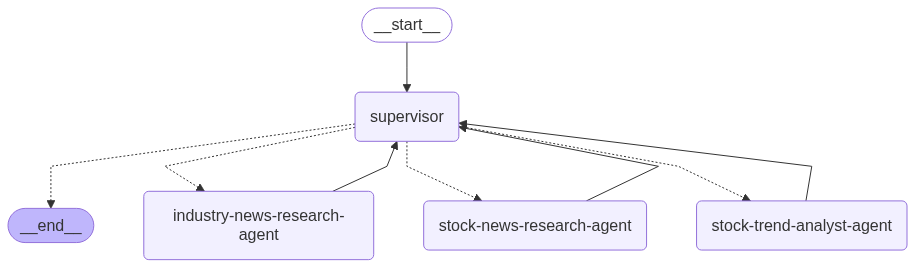

In [95]:
# Model used for the agents
chat_llm = init_chat_model(**models[0])

# Create the agents & cards
stock_research_agent = stock_research.create_stock_research_agent(chat_llm)
stock_research_agent_card = stock_research.get_agent_card()

industry_research_agent = industry_research.create_industry_research_agent(chat_llm)
industry_research_agent_card = industry_research.get_agent_card()

stock_trend_analyst_agent = trend_analysis.create_stock_trend_analyst_agent(chat_llm)
stock_trend_analyst_agent_card = trend_analysis.get_agent_card()


from typing import List, Literal
from enum import Enum
from pydantic import BaseModel, confloat

class DecisionEnum(str, Enum):
    BUY = "BUY"
    HOLD = "HOLD"
    SELL = "SELL"

class StockAnalysisSchema(BaseModel):
    report: str = Field(..., description="Aggregated report on the stock")
    reasons: List[str] = Field(..., description="Reasons to support the decision")
    decision: DecisionEnum = Field(..., description="Recommended action for the stock")
    confidence: confloat(ge=0, le=1) = Field(..., description="Confidence in the recommendation")
    
prompt = (
    "You are a supervisor managing multiple agents:\n"
    "You use your team of agents to analyze the stocks \n"
    "You generate a report in the provided structured format. The report is used by humans to make stock purchase decision\n"
    f"- stock_research_agent. Here are the details: {stock_research_agent_card}\n"
    f"- industry_research_agent. Here are the details: {industry_research_agent_card}\n"
    f"- stock_trend_analyst_agent. Here are the details: {stock_trend_analyst_agent_card}\n"
    "Assign work to one agent at a time, do not call agents in parallel.\n"
    "Use only the information provided by the agents.\n"
    "The report should be in JSON format with these attributes : {executive_summary, decision (BUY or HOLD or SELL), recent_news, industry_trend, stock_trend}\n"
)

# Model used by the supervisor
# SETUP RESPONSE FORMAT
chat_llm = init_chat_model(**models[4])

supervisor = create_supervisor(
    model = chat_llm,
    agents = [stock_research_agent, industry_research_agent, stock_trend_analyst_agent], 
    prompt = prompt,
    response_format = StockAnalysisSchema,
).compile()

supervisor

In [96]:
messages = {"messages":[HumanMessage(content="AAPL")],"remaining_steps": 10}
response  = supervisor.invoke(messages)


In [97]:
print(response["messages"][-1].content)

{"executive_summary": "Apple Inc. (AAPL) has experienced a decline in its stock price due to uncertainty about its AI strategy and legal challenges, but analysts remain optimistic about its long-term prospects.", "decision": "HOLD", "recent_news": "AAPL has faced some headwinds leading to a notable decline in its stock price, but analyst sentiments remain optimistic about the company’s long-term prospects.", "industry_trend": "The Technology sector, specifically the Consumer Electronics sub-sector, has been affected by recent industry trends, including the impact of AI on consumer electronics.", "stock_trend": "The stock price history for Apple Inc. (AAPL) shows a long-term trend with significant fluctuations in both price and volume, and the stock may experience further volatility as it addresses ongoing strategic concerns and legal challenges."}


In [98]:
response

{'messages': [HumanMessage(content='AAPL', additional_kwargs={}, response_metadata={}, id='cdca8e86-f075-4e35-8e53-7e2b928cc04a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rvj4rqg12', 'function': {'arguments': 'null', 'name': 'transfer_to_stock-news-research-agent'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 1532, 'total_tokens': 1546, 'completion_time': 0.033136951, 'prompt_time': 0.125924081, 'queue_time': 0.196288986, 'total_time': 0.159061032}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--9e91371b-b30d-429e-bbf8-aefcd81e5ae1-0', tool_calls=[{'name': 'transfer_to_stock-news-research-agent', 'args': {}, 'id': 'rvj4rqg12', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1532, 'output_tokens': 14, 'total_tokens': 1546}),
  ToolMessage(content='Successfully t

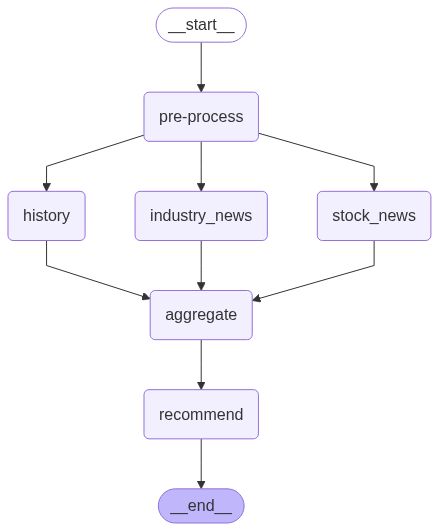

In [6]:
from typing import TypedDict, Dict, List
from langgraph.graph import StateGraph, START, END

# ---- Define State ----
class PortfolioState(TypedDict):
    tickers: List[str]
    research: Dict[str, Dict]          # ticker → { history, stock_news, industry_news }
    recommendations: Dict[str, str]    # ticker → action

# ---- Build Graph ----
graph = StateGraph(PortfolioState)

# Input Node
def portfolio_input(state: PortfolioState):
    return {"tickers": state.get("tickers", []), "research": {}}

graph.add_node("pre-process", portfolio_input)

# ---- Research Nodes ----
def history_agent(state: PortfolioState):
    research = state["research"].copy()
    for t in state["tickers"]:
        research.setdefault(t, {})
        research[t]["history"] = f"History summary for {t}"
    return {"research": research}

def stock_news_agent(state: PortfolioState):
    research = state["research"].copy()
    for t in state["tickers"]:
        research.setdefault(t, {})
        research[t]["stock_news"] = f"Company-specific news for {t}"
    return {"research": research}

def industry_news_agent(state: PortfolioState):
    research = state["research"].copy()
    for t in state["tickers"]:
        research.setdefault(t, {})
        research[t]["industry_news"] = f"Industry-wide news for {t}"
    return {"research": research}

graph.add_node("history", history_agent)
graph.add_node("stock_news", stock_news_agent)
graph.add_node("industry_news", industry_news_agent)

# ---- Aggregator Node ----
def aggregate(state: PortfolioState):
    # In a real workflow, you'd normalize into structured format here
    return {"research": state["research"]}

graph.add_node("aggregate", aggregate)

# ---- Recommendation Node ----
def recommendation_agent(state: PortfolioState):
    recs = {}
    for t in state["tickers"]:
        recs[t] = "HOLD"   # placeholder logic
    return {"recommendations": recs}

graph.add_node("recommend", recommendation_agent)

# ---- Wire Edges ----
graph.add_edge(START, "pre-process")
graph.add_edge("pre-process", "history")
graph.add_edge("pre-process", "stock_news")
graph.add_edge("pre-process", "industry_news")
graph.add_edge(["history", "stock_news", "industry_news"], "aggregate")
graph.add_edge("aggregate", "recommend")
graph.add_edge("recommend", END)

# ---- Compile ----
research_agent = graph.compile()
research_agent